# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

For this project, I performed an A/B test for an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product.
The goal of this project is to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers
random.seed(42)

### Description of Data
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [6]:
df.converted.value_counts(normalize=True)[1]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
unmatch_1 = df[(df.group == 'treatment') & (df.landing_page != 'new_page')].shape[0]

In [8]:
unmatch_2 = df[(df.group == 'control') & (df.landing_page != 'old_page')].shape[0]

In [9]:
unmatch_1 + unmatch_2

3893

**f.** Do any of the rows have missing values?

In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
# timeframe of collected data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.timestamp.max() - df.timestamp.min()

Timedelta('21 days 23:59:49.081927')

### Handling rows where the group and landing_page columns don't match
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.** create a new dataset after deleting rows, and store it in **df2**.

In [12]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

index_1 = df[(df.group == 'treatment') & (df.landing_page != 'new_page')].index
index_2 = df[(df.group == 'control') & (df.landing_page != 'old_page')].index
df.drop(index_1, inplace = True)
df.drop(index_2, inplace = True)

In [13]:
df2 = df

In [14]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### Checking for duplicate user_id 

**a.** How many unique **user_id**s are in **df2**?

In [15]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2[df2.user_id.duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [17]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [18]:
# Remove one of the rows with a duplicate user_id
dup_index = df2[df2.user_id.duplicated() == True].index
df2.drop(dup_index, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted


### Conversion Rate

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [19]:
df2.converted.value_counts(normalize = True)[1]

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
conv_rate_cont = df2[df2.group == 'control'].converted.value_counts(normalize = True)[1]
conv_rate_cont

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
conv_rate_treat = df2[df2.group == 'treatment'].converted.value_counts(normalize = True)[1]
conv_rate_treat

0.11880806551510564

In [22]:
# Calculate the actual difference between the conversion rates for the two groups.
obs_diff = conv_rate_treat - conv_rate_cont
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [23]:
df2.landing_page.value_counts(normalize=True)['new_page']

0.5000619442226688

**e.** Considering results from parts (a) through (d) above, explain below whether the new `treatment` group users lead to more conversions.

>**Treatment group users have a slightly lower conversion rate than that of the control group users**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### Hypothesis Formulation
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page. 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>$𝐻_0$: $𝑝_{𝑛𝑒𝑤}$ - $𝑝_{𝑜𝑙𝑑}$ <= 0

>$𝐻_1$: $𝑝_{𝑛𝑒𝑤}$ - $𝑝_{𝑜𝑙𝑑}$ > 0

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [24]:
p_new = df2.converted.value_counts(normalize=True)[1]

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [25]:
p_old = df2.converted.value_counts(normalize=True)[1]

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
n_new = df2.group.value_counts()['treatment']

**d.** What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old = df2.group.value_counts()['control']

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  

In [28]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new, p_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [29]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old, p_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [30]:
print((new_page_converted).mean() - (old_page_converted).mean())

0.0006036160059677137


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [31]:
# Sampling distribution 
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  <br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

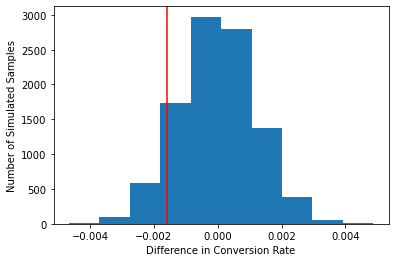

In [32]:
plt.hist(p_diffs)
plt.axvline(x = obs_diff, color = 'r')
plt.xlabel('Difference in Conversion Rate')
plt.ylabel('Number of Simulated Samples');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [33]:
(p_diffs > obs_diff).mean()

0.9033

**k.**
- What is this value called in scientific studies?  
- What does this value signify in terms of whether or not there is a difference between the new and old pages?

- **This value is called p-value**
- **It states that the probability of observing a difference in conversion rates between the two groups that is equal to or greater than (-0.001578) given that the null hypothesis is true, is 0.9062.**
- **Given alpha = 0.05, we fail to reject the null hypothesis, and we conclude that there is no evidence that conversion rate is higher when using the new page.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[(df2.landing_page == 'old_page') & (df2.converted == 1)].shape[0]

# number of conversions with the new_page
convert_new =df2[(df2.landing_page == 'new_page') & (df2.converted == 1)].shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2.landing_page == 'old_page'].user_id.nunique()

# number of individuals who received new_page
n_new = df2[df2.landing_page == 'new_page'].user_id.nunique()

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value. 

In [35]:
import statsmodels.api as sm

z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**The p-value is similar to the one we computed earlier (0.905 vs 0.9033). Both values are significantly greater than alpha (0.05). Regarding z-test, comparing $Z_{score}$ (1.3109) to the critical value of $Z_{0.05}$ (1.645), and considering that our hypothesis is a right-tailed test, we cannot reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will perform a logistic regression to confirm the results of our A/B test.

**a.** The goal is to use **statsmodels** library to fit our regression model to see if there is a significant difference in conversion based on the page-type a customer receives. First, we need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [36]:
df2['intercept'] = 1
df2[['not_ab_page','ab_page']] = pd.get_dummies(df2['group'])

**b.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [37]:
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**c.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-11-28 01:19 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**d.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

>**In Part II, our hypothesis was one-sided (right-sided). However, in linear logistic regression, our hypothesis is two-sided, that is, there is no linear relationship between the response variable and the explanatory variables (all the coefficients in the model are equal to zero).**<br>
>**Given alpha = 0.05, p-value = 0.1899, we can not reject the null hypothesis, and we conclude that there is no linear relationship between conversion rate and the page that the user received.**

**e.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**It depends on the purpose of the model and the product itself.<br><br>
If the purpose of our model is to detect whether there is a linear relationship between conversion rate and landing page, then our model above would be sufficent to detect that (We have proved above tht we found no statistical evidence of such relationship). However, if the purpose of our model is to predict whether the user will convert or not, then it would be better to add other relevant variables to the model to predict conversion.<br>
It is worth noting, however, that adding, for instance, collinear variables to our model could result in multicollinearity which would affect the accuracy and predictive power of our model.<br><br>
Additionally, and depending on the product, it might help to add variables that capture user characteristics like gender or age group to help better predict whether the user will convert or not.**

**f. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. Read **countries.csv** dataset, merge together your `df2` datasets on the appropriate rows, and call the resulting dataframe `df_merged`.

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [40]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
# Join with the df2 dataframe
df_merged = df2.join(countries_df.set_index('user_id'), on= 'user_id', how = 'inner')

In [42]:
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,not_ab_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [43]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])

In [44]:
# fit model and display summary
country_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK']]).fit()
country_model.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-11-28 01:22 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

> **Looking at the p-values, and knowing that alpha = 0.05, we can not reject the null hypothesis, and we conclude that there is no linear relationship between conversion rate and the user's country.**

**g. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 

In [45]:
# Fit your model, and summarize the results
df_merged['ab_CA'] = df_merged['ab_page'] * df_merged['CA']
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']

interaction_model = sm.Logit(df_merged['converted'], df_merged[['intercept','CA', 'UK', 'ab_page', 'ab_CA', 'ab_UK']]).fit()
interaction_model.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-11-28 01:23 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
ab_CA        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

<a id='conclusion'></a>
### Conclusion

>**Again, we can see that even after introducing interaction terms to the model to account for differences in the relationship between conversion rate and landing page accross different countries, the p-values are significantly higher than alpha (0.05), so we cannot reject the null hypothesis and conclude that there is no relationship between conversion rate and landing page or country or the interaction term.<br><br>
According to our tests and regression models, we should not launch the new page and rather stick to the old page. However, it is worth noting that the timeframe of the collected data is only ~ 22 days. We would recommend to run the experiment for a longer period of time to account for changes in behaviour of users based on time and to allow users to adjust to change, and then re run the test so as to reach a more conclusive result.**